In [72]:
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import stan
from sklearn.model_selection import train_test_split
import nest_asyncio
nest_asyncio.apply()

In [73]:
# Creating the dataframe from the insurance.csv retrieved from
# https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv
df = pd.read_csv('insurance.csv')
list_of_columns = ['bmi', 'age', 'children', 'charges']
df = df[list_of_columns]
df

,bmi,age,children,charges
0,27.900,19,0,16884.92400
1,33.770,18,1,1725.55230
2,33.000,28,3,4449.46200
3,22.705,33,0,21984.47061
4,28.880,32,0,3866.85520
...,...,...,...,...
1333,30.970,50,3,10600.54830
1334,31.920,18,0,2205.98080
1335,36.850,18,0,1629.83350
1336,25.800,21,0,2007.94500


In [74]:
# Standardize predicters for each column/variable
for i in list_of_columns:
    df[i] = (df[i] - df[i].mean()) / df[i].std()

# Create train data and test data from dataframe
train_data, test_data = train_test_split(df, test_size = 0.2, random_state = 42)
train_data

,bmi,age,children,charges
560,-1.756817,0.483487,0.750799,-0.336629
1285,-1.040210,0.554662,-0.908274,-0.391061
1142,-0.951659,0.910535,-0.908274,1.143481
969,0.599621,-0.014735,3.239407,-0.385928
486,-1.507562,1.052884,1.580335,-0.065654
...,...,...,...,...
1095,0.112591,-1.509401,2.409871,-0.719176
1130,-1.114003,-0.014735,3.239407,-0.387128
1294,-0.900005,1.337582,-0.908274,-0.110594
860,2.777318,-0.157084,0.750799,2.712061


In [75]:
# Create data to provide to the stan model
n = train_data.shape[0]                                   # Datapoints in train data
k = train_data.shape[1] - 1                               # Number of predictors minus 1 ('charges' not counted)
x = train_data[['bmi', 'age', 'children']].to_numpy()     # Predictor matrix (again, not including 'charges')
y = train_data['charges'].to_numpy()                      # Outcome variable (insurance charges)
new_n = test_data.shape[0]                                # Datapoints in test data
new_x = test_data[['bmi', 'age', 'children']].to_numpy()  # Predictor matrix for test data ('charges not included)
tau_0, tau_1, sigma_alpha = 0.001, 0.001, 1
sigma_beta = np.repeat(sigma_alpha, k)

In [76]:
# Placing data into data dictionary
data = {
    'N': n,
    'K': k,
    'x': x,
    'y': y,
    'new_n': new_n,
    'new_x': new_x,
    'tau_0': tau_0,
    'tau_1': tau_1,
    'sigma_alpha': sigma_alpha,
    'sigma_beta': sigma_beta
}

# Building the stan model
vectorized_program_code = '''
data {
    // Inputs
    int<lower=0> N;
    int<lower=1> K;
    matrix[N, K] x;
    vector[N] y;
    int<lower=0> new_n;
    matrix[new_n, K] new_x;

    // Hyperparameters
    real<lower=0> tau_0;
    real<lower=0> tau_1;
    real<lower=0> sigma_alpha;
    vector<lower=0>[K] sigma_beta;
}

parameters {
    real alpha;
    vector[K] beta;
    real<lower=0> sigma2;
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma2);
}

model {
    // Priors 
    target += inv_gamma_lpdf(sigma | tau_0, tau_1);
    target += normal_lpdf(alpha | 0, sigma_alpha);
    target += multi_normal_lpdf(beta | rep_vector(0, K), diag_matrix(sigma_beta));
    
    // Likelihood
    target += normal_lpdf(y | x * beta + rep_vector(alpha, N), sigma);
}

generated quantities {
    array[new_n] real predictions = normal_rng(rep_vector(alpha, new_n) + new_x * beta, rep_vector(sigma, new_n));
}
'''

stanModel = stan.build(vectorized_program_code, data = data, random_seed = 42)
vectorizedFit = stanModel.sample(num_chains = 4, num_samples = 2000, num_warmup = 1000)

Building...



Building: 32.9s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   8% (901/12000)
Sampling:  33% (3901/12000)
Sampling:  58% (6901/12000)
Sampling:  82% (9900/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.001465 seconds
  1000 transitions using 10 leapfrog steps per transition would take 14.65 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001469 seconds
  1000 transitions using 10 leapfrog steps per transition would take 14.69 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001463 second

In [77]:
# Calculate the root-mean-squared error (RMSE) between the predictive means and the actual charges in the test set
sample_mean = np.mean(vectorizedFit['predictions'], axis = 1)
sample_true = test_data['charges'].to_numpy()
rmse = np.sqrt(np.mean((sample_true - sample_mean) ** 2))
rmse

np.float64(0.9459053175166177)

In [78]:
# Show data numerically
az.summary(vectorizedFit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.006,0.029,-0.049,0.060,0.000,0.000,10571.0,5683.0,1.0
beta[0],0.167,0.029,0.115,0.224,0.000,0.000,10121.0,5964.0,1.0
beta[1],0.256,0.028,0.202,0.309,0.000,0.000,10793.0,6524.0,1.0
beta[2],0.056,0.029,0.000,0.107,0.000,0.000,10493.0,6871.0,1.0
sigma2,0.881,0.038,0.814,0.955,0.000,0.000,10791.0,6507.0,1.0
...,...,...,...,...,...,...,...,...,...
predictions[263],0.508,0.954,-1.238,2.298,0.011,0.007,7897.0,7960.0,1.0
predictions[264],0.212,0.953,-1.571,2.025,0.011,0.008,7310.0,7215.0,1.0
predictions[265],-0.091,0.941,-1.792,1.738,0.010,0.008,8048.0,7512.0,1.0
predictions[266],0.682,0.941,-1.097,2.405,0.010,0.007,8030.0,7592.0,1.0


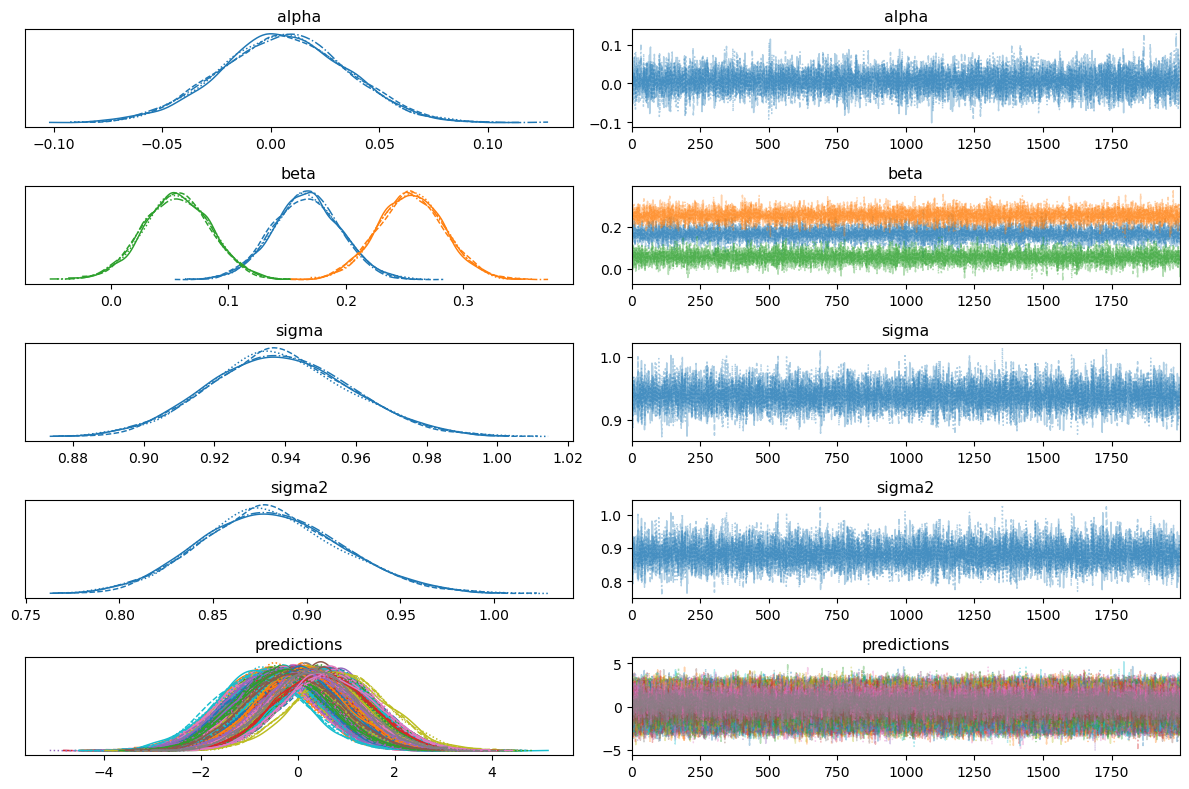

In [79]:
# Legend not applied since it would have 267 different lines on it
# Show data graphically
f = az.plot_trace(vectorizedFit, var_names = ['alpha', 'beta', 'sigma', 'sigma2', 'predictions'], figsize = (12, 8))
plt.tight_layout()

## How good are your predictions? ##

RMSE, or Root Mean Squared Error, measures the average magnitude of the differences between the predicted and actual values in our model. Our RMSE value was 0.9459. Since the model uses only 3 predictors and weakly informative priors, we can argue that the model is decently accurate in its predictions, but not perfect.

## What information did you lose by computing the predictive means? ##

By computing the predictive means, we lost information about the uncertainity in the predictive distribution. This is significant because RMSE value does not provide us with the confidence level or variability of the results. Some information lost includes the predictive variance, which is how uncertain the model is about each prediction, the predictive distribution skew, and the intervals which show the spread that the model would expect to find in unseen data.

## How could you possibly propagate the uncertainty information encoded in the predictive distribution to obtain a distribution over the test RMSE values? ##

To propogate the uncertainty information encoded in the predictive distribution and obtain a distrubution over the test RMSE values, we could sample multiple sets of predicted values that were found from the posterior predictive distrbution. Then, we would calculate the RMSE value for each sample, providing us with a distribution over RMSE values. Instead of one RMSE value, this distribution would help us get a glimpse into the uncertainty of the model's overall predictions.